# Recreating results in report

Make sure that all the data and model weights are in Data before running this notebook.  
Link to data : https://dtudk-my.sharepoint.com/:f:/g/personal/s223596_dtu_dk/EiIC5mHl0iZMuCK47iEgRdIBbMPaBinPk3PgctZn6AdOqg?e=cGTuXU

## 1. Get objects locations suggestions, extract and predict
Step-by-step
1. Get object location suggestions - Run Selective Search implemented from cv2.ximgproc in "single" mode on the RGB images.
2. Filter object suggestions - Boxes are filtered if they are not within 3-10% width and height of the longer side of the image.     
   That should be approximate size for all kernels coming through.
3. Extract image patches from suggestions
4. Predict the label with the pretrained VGG16 based classifier

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cv2
import torch
import glob
import numpy as np
import torchvision.transforms as transforms
import json
import os

label_name_arr = ["Background","MaizeHealthy","MaizeUnhealthy"]
label_colors = [(0,0,255),(0,255,0),(255,0,0)]
label_colors_groundtruth = [tuple([int(c * 2/3) for c in l_colors]) for l_colors in label_colors] # little darker
label_colors_plt = [[float(c)/255.0 for c in l_colors] for l_colors in label_colors]
label_colors_groundtruth_plt = [[float(c)/255.0 for c in l_colors] for l_colors in label_colors_groundtruth]

In [2]:
from classification_model import ClassificationModel
from object_location_suggestions import get_box_suggestions_with_selective_search

# Load in pretrained classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print("Loading in classifier ... ", end = "")
classifier = ClassificationModel()
classifier.load_state_dict(torch.load("./Data/model_loadings.pt",map_location=device))
classifier.to(device).eval()
print("DONE")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128),antialias=None),
])
    

def output_activate(pred_logits):
    return torch.nn.Softmax(dim=1)(pred_logits)


def predict(x):
    x = transform(x.astype(np.float32))[None,:,:,:]  # transform to target size and dimensions
    x.to(device)   
    if "cuda" in str(device):
        x = x.cuda()  # Set type to torch.cuda.floattensor type
    pred_logits = classifier.forward(x)
    return output_activate(pred_logits).cpu().detach().numpy().ravel()



# -------------------------------------------------------------------------------

path_to_images_rgb = glob.glob("./Data/test_data/*_rgb.jpg")
bbox_suggestions_with_labels = dict()
N = len(path_to_images_rgb)

for i, filename in enumerate(path_to_images_rgb):
    print(i+1, " of ", N, end="\r")

    img_bgr = cv2.imread(filename)
    img_npy = np.load(filename.replace("_rgb.jpg",".npy"))
    
    bbox_suggestions_with_labels[filename] = {"label" : [], "pred_label_liklihood" : [], "bbox" : []}
    
    # 1-2. Get box suggestions and filter by width and height
    bbox_suggestions = get_box_suggestions_with_selective_search(img_bgr)

    for x,y,w,h in bbox_suggestions:
        # 3. Extract patch
        patch = img_npy[y:y+h, x:x+w,:]

        # 4. Predict label on patch
        pred_label_liklihood_arr = predict(patch)
        
        label = int(np.argmax(pred_label_liklihood_arr))

        bbox_suggestions_with_labels[filename]["label"].append(int(label))
        bbox_suggestions_with_labels[filename]["pred_label_liklihood"].append(float(pred_label_liklihood_arr[label]))
        bbox_suggestions_with_labels[filename]["bbox"].append([int(x),int(y),int(w),int(h)])
        
     
with open(os.path.join("./Data/bbox_suggestions_with_labels.json"),"w") as fp:
    json.dump(bbox_suggestions_with_labels, fp)


Loading in classifier ... DONE


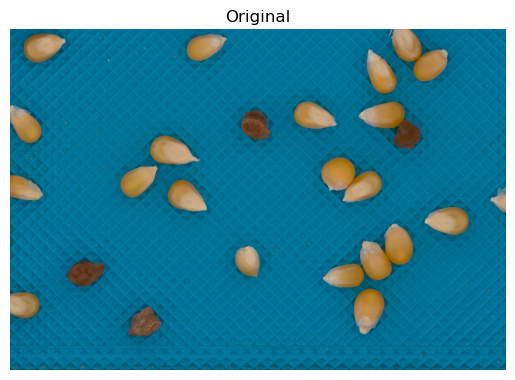

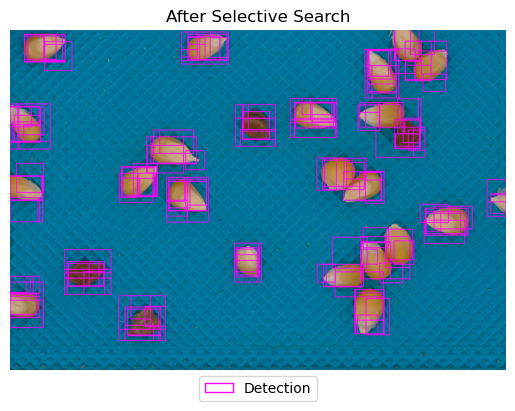

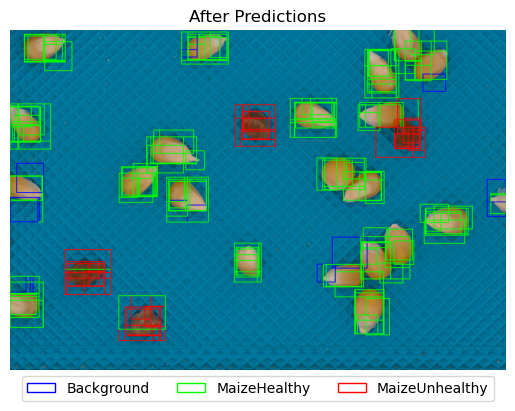

In [2]:
# Showing the results
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # UNSAFE - but stops the kernel from crashing

with open("./Data/bbox_suggestions_with_labels.json") as fp:
    bbox_suggestions_with_labels = json.load(fp)

target_image_path = "./Data/test_data\\test_1_rgb.jpg"
bbox_arr = bbox_suggestions_with_labels[target_image_path]

img_bgr = cv2.imread(target_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb_with_pred = img_rgb.copy()
for label, (x,y,w,h) in zip(bbox_arr["label"], bbox_arr["bbox"]):
    img_rgb = cv2.rectangle(img_rgb, (x,y), (x+w, y+h), color=(255,0,255), thickness=2)
    img_rgb_with_pred = cv2.rectangle(img_rgb_with_pred, (x,y), (x+w, y+h), color=label_colors[label], thickness=2)

# Original
plt.figure()
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")
plt.show()

# Selective Search
plt.figure()
plt.imshow(img_rgb)
plt.title("After Selective Search")
plt.axis("off")
plt.legend(handles=[Patch(facecolor='w', edgecolor=(1.0,0,1.0),label='Detection')], loc="lower center", bbox_to_anchor=(0.5, -0.11))
legend_elements = [Patch(facecolor='w', edgecolor=label_colors_plt[0],label=label_name_arr[0]), 
                   Patch(facecolor='w', edgecolor=label_colors_plt[1],label=label_name_arr[1]), 
                   Patch(facecolor='w', edgecolor=label_colors_plt[2],label=label_name_arr[2])]
plt.show()

# With predictions
plt.figure()
plt.imshow(img_rgb_with_pred)
plt.title("After Predictions")
plt.axis("off")
plt.legend(handles=legend_elements, ncols=3,loc="lower center", bbox_to_anchor=(0.5, -0.11))
plt.show()

### Classifier training results - Learning curve 


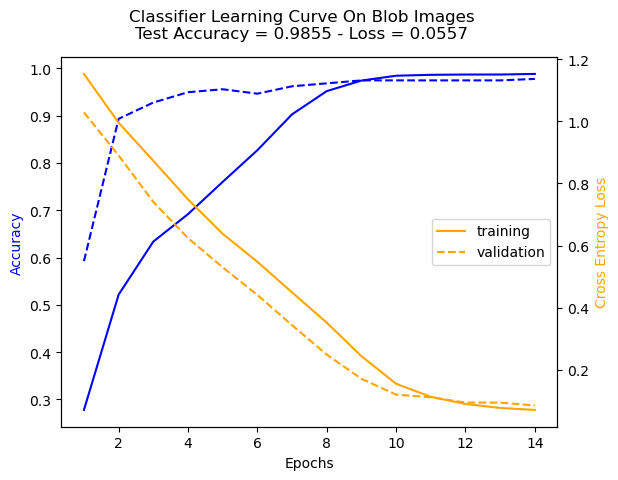

In [3]:
# Full training of the classifier code can be seen in "training_classifier.py" 
# But to save time here is the results : 
import json
import matplotlib.pyplot as plt
import numpy as np

# Training lopp in "training_classifier.py"
with open("./Data/classifier_training_results.json") as fp:
    learning_curve_dict = json.load(fp)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

epochs = np.arange(1,len(learning_curve_dict["train_acc"])+1)

ax1.plot(epochs,learning_curve_dict["train_acc"],"b-")
ax1.plot(epochs,learning_curve_dict["valid_acc"],"b--")

ax2.plot(epochs,learning_curve_dict["train_loss"],color="orange",linestyle="-",label="training")
ax2.plot(epochs,learning_curve_dict["valid_loss"],color="orange",linestyle="--",label="validation")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color="b")
ax2.set_ylabel("Cross Entropy Loss", color="orange")

plt.legend(loc = "right")
plt.suptitle("Classifier Learning Curve On Blob Images\nTest Accuracy = "+str(round(learning_curve_dict["test_acc"][0], 4)) + " - Loss = " + str(round(learning_curve_dict["test_loss"][0], 4)))
plt.show()

## 2. Suppression
- Using Non-maximum suppression with Intersect-over-Union (IoU) and Confidence Score

### Training results 

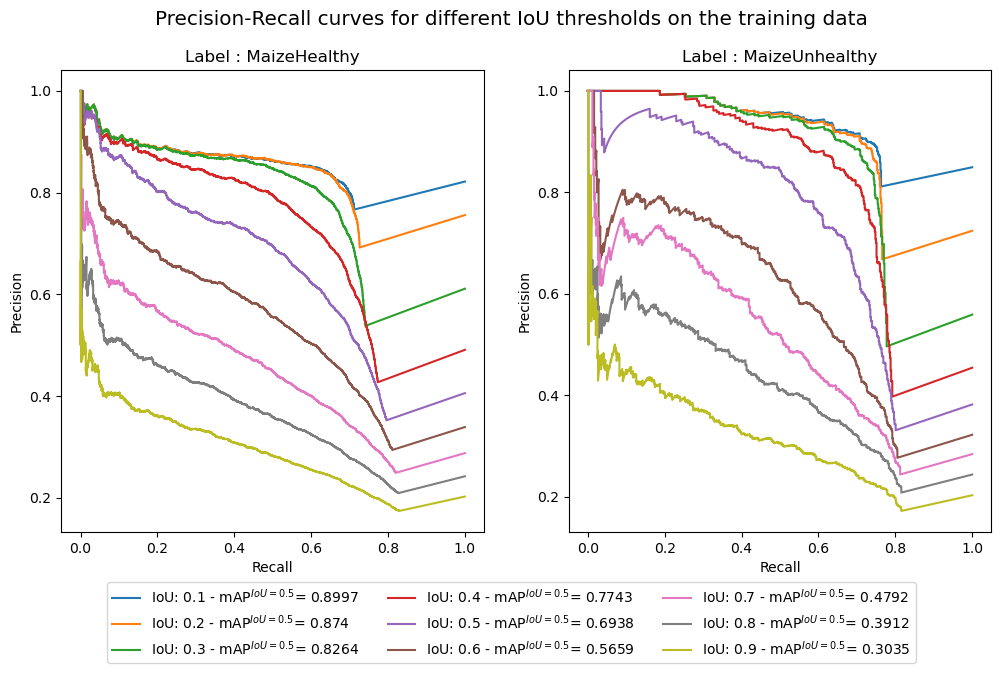

In [4]:
# To get the training results you need to run "nms.py" and then "plot_nms_statistics.py" but to save time here is the nms stats
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # UNSAFE - but stops the kernel from crashing

import matplotlib.colors as mcolors 
with open("./Data/nms_train_stats_calculated.json") as fp:
    nms_train_stats = json.load(fp)

color_arr = list(mcolors.TABLEAU_COLORS.values())

fig, axs = plt.subplots(1,2, figsize=(12,6))
for i, (iou_threshold_str, label_value_arr) in enumerate(nms_train_stats.items()):
    if iou_threshold_str == "iou_final_stats":
        continue
    for label_index_without_background in range(2):
        precision = nms_train_stats[iou_threshold_str][label_index_without_background]["precision"]
        recall = nms_train_stats[iou_threshold_str][label_index_without_background]["recall"]
        axs[label_index_without_background].plot(recall,precision,color=color_arr[i])


for label_index_without_background in range(2):
    axs[label_index_without_background].set_title("Label : " + label_name_arr[label_index_without_background+1])
    axs[label_index_without_background].set_xlabel("Recall")
    axs[label_index_without_background].set_ylabel("Precision")
fig.suptitle("Precision-Recall curves for different IoU thresholds on the training data", fontsize="x-large")   
fig.legend([legend.replace("mAP:", "mAP$^{IoU=0.5}$=") for legend in nms_train_stats["iou_final_stats"]],fontsize="medium", ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.12) )
plt.show()

### Testing results

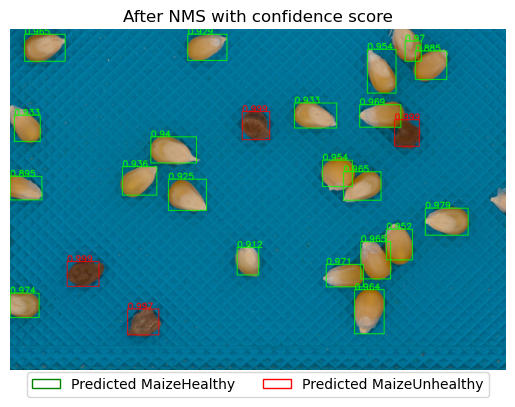

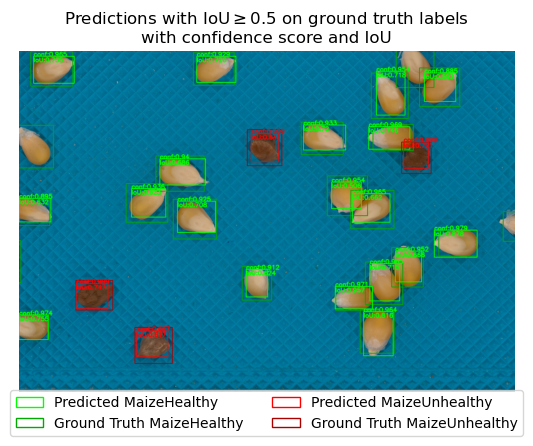

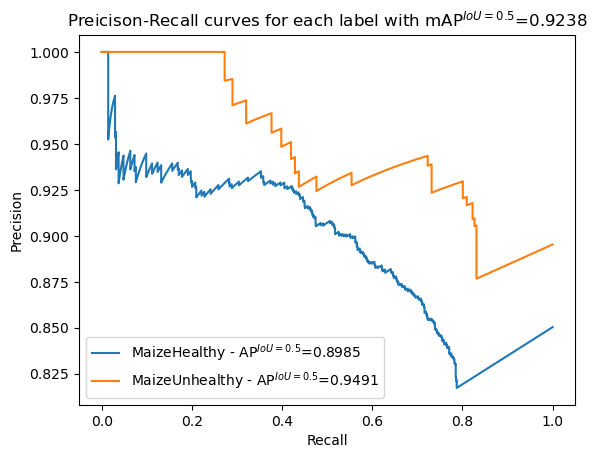

In [6]:
import re
from nms import get_ypred_ytrue
from sklearn.metrics import precision_recall_curve, average_precision_score


with open("./Data/bbox_suggestions_with_labels.json") as fp:
    bbox_dict_suggestions_with_labels = json.load(fp)

# Get ground truth
with open("./Data/test_bbox_groundtruth.json") as fp:
    bbox_dict_groundtruth = json.load(fp)



# Set optimal thresholding values
iou_threshold = 0.1
confidence_score_threshold = 0.8

y_true = [[],[]]
y_pred = [[],[]]



for filename, bbox_suggestions in bbox_dict_suggestions_with_labels.items():
    image_index = re.findall("\d+",filename)[-1]
    # Get ground truth
    bbox_groundtruth = np.array(bbox_dict_groundtruth[image_index]["bbox"])
    label_groundtruth = np.array(bbox_dict_groundtruth[image_index]["label"])
    

    if filename == target_image_path:
        img_plot = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        img_plot_with_gt = img_plot.copy()

    avg_precision_arr = []

    # Calculate for each label (skipping background label)
    for label in range(1,3):

        # Get all bbox and predicted label confidence scores
        label_mask = (np.array(bbox_suggestions["label"]) == label)
        bbox_arr_filtered = np.array(bbox_suggestions["bbox"])[label_mask]
        pred_label_confidence_score_filtered = np.array(bbox_suggestions["pred_label_liklihood"])[label_mask]

        # Apply NMS with both confidence score and IoU thresholds
        idxs = cv2.dnn.NMSBoxes(bbox_arr_filtered, pred_label_confidence_score_filtered, confidence_score_threshold, iou_threshold)   

        bbox_arr_nms = bbox_arr_filtered[idxs]
        pred_label_confidence_score_nms = pred_label_confidence_score_filtered[idxs]


        # Compare to ground truth
        bbox_gt_masked = bbox_groundtruth[label_groundtruth == label]

        # If no boxes were found and non are in the image then skip it
        if ((bbox_gt_masked.shape[0] == 0) and (bbox_arr_nms.shape[0] == 0)): 
            continue

        # Remove all duplicate prediction boxes on ground truth and duplicate ground truth boxes on prediction boxes by using IoU
        y_pred_tmp, y_true_tmp, pred_boxes_found, gt_boxes_found, iou_of_pred_boxes_found = get_ypred_ytrue(bbox_gt_masked, bbox_arr_nms, pred_label_confidence_score_nms)
        y_pred[label-1].extend(y_pred_tmp)
        y_true[label-1].extend(y_true_tmp)
        


        if filename == target_image_path:
            # Plot NMS suggestions
            for (x,y,w,h), label_conf_score in zip(bbox_arr_nms, pred_label_confidence_score_nms):
                img_plot = cv2.rectangle(img_plot, (x,y), (x+w,y+h), color=label_colors[label], thickness=2)
                img_plot = cv2.putText(img_plot, str(round(label_conf_score,3)), (x,y),  cv2.FONT_HERSHEY_SIMPLEX , fontScale=1, color=label_colors[label], thickness=2, lineType=cv2.LINE_AA)

            # Plot ground truth
            for x,y,w,h in bbox_gt_masked:
                img_plot_with_gt = cv2.rectangle(img_plot_with_gt, (x,y), (x+w,y+h), color=label_colors_groundtruth[label], thickness=2)

            for (x,y,w,h), conf_score, iou in zip(bbox_arr_nms[pred_boxes_found], pred_label_confidence_score_nms[pred_boxes_found], iou_of_pred_boxes_found):
                img_plot_with_gt = cv2.rectangle(img_plot_with_gt, (x,y), (x+w,y+h), color=label_colors[label], thickness=2)
                img_plot_with_gt = cv2.putText(img_plot_with_gt, "conf:" + str(round(conf_score,3)) , (x,y),  cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.7, color=label_colors[label], thickness=2, lineType=cv2.LINE_AA)
                img_plot_with_gt = cv2.putText(img_plot_with_gt, "IoU:" + str(round(iou,3)) , (x,y+20),  cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.7, color=label_colors[label], thickness=2, lineType=cv2.LINE_AA)
            

    
    if filename == target_image_path:
        plt.figure()
        plt.imshow(img_plot)
        plt.title("After NMS with confidence score")
        plt.axis("off")
        legend_elements = [Patch(facecolor='w', edgecolor='g',label='Predicted '+label_name_arr[1]), 
                            Patch(facecolor='w', edgecolor='r',label='Predicted '+label_name_arr[2])]
        plt.legend(handles=legend_elements, ncols=2,loc="lower center", bbox_to_anchor=(0.5, -0.1))
        plt.show()

        plt.figure()
        plt.imshow(img_plot_with_gt)
        plt.title("Predictions with IoU$\geq$0.5 on ground truth labels \nwith confidence score and IoU")
        plt.axis("off")
        legend_elements = [Patch(facecolor='w', edgecolor=label_colors_plt[1],label='Predicted '+label_name_arr[1]), 
                           Patch(facecolor='w', edgecolor=label_colors_groundtruth_plt[1],label='Ground Truth '+label_name_arr[1]), 
                            Patch(facecolor='w', edgecolor=label_colors_plt[2],label='Predicted '+label_name_arr[2]), 
                            Patch(facecolor='w', edgecolor=label_colors_groundtruth_plt[2] ,label='Ground Truth '+label_name_arr[2])]
        plt.legend(handles=legend_elements, ncols=2,loc="lower center", bbox_to_anchor=(0.5, -0.15))
        plt.show()


    
# Calculate precision-recall curve and AP
plt.figure()
avg_precision_arr = [0.0,0.0]
for i in range(2):
    sorted_index = np.argsort(y_pred[i])
    y_true_label = np.array(y_true[i])[sorted_index]
    y_pred_label = np.array(y_pred[i])[sorted_index]

    precision, recall, _ = precision_recall_curve(y_true_label, y_pred_label)
    avg_precision_arr[i] = average_precision_score(y_true_label, y_pred_label)
    plt.plot(recall, precision, label=label_name_arr[i+1]+" - AP$^{IoU=0.5}$="+str(round(avg_precision_arr[i], 4)))
    plt.xlabel("Recall")
    plt.ylabel("Precision")

plt.legend(loc="lower left")
plt.title("Preicison-Recall curves for each label with mAP$^{IoU=0.5}$=" + str(np.round(np.mean(avg_precision_arr), 4)) )
        
plt.show()